# PASC DataQuest 2.0

The model used was a GradientBoostingClassifier that retured accuracies of 89%(dev), 88.4%(Public LB) and 85.9%(Private LB).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [2]:
train = pd.read_csv("C:\\01Data\\Urjit\\Exercise PICT\\doctor_train.csv")
test = pd.read_csv("C:\\01Data\\Urjit\\Exercise PICT\\doctor_test.csv")

# Imputation

Missing values in 'age' were replaced using median as it had a slightly skewed distribution and the missing values in 'Money' were replaced with mean.

In [3]:
def impute_na(df, variable, value):
    df[variable].fillna(value, inplace=True)

In [4]:
impute_na(train,'age',train['age'].median())
impute_na(test,'age',train['age'].median())

impute_na(train,'Money',train['Money'].mean())
impute_na(test,'Money',train['Money'].mean())

Missing value imputation for categorical variables was done using mode imputation.

In [5]:
train['edu'].mode()

0    secondary
dtype: object

In [6]:
impute_na(train,'edu','secondary')
impute_na(test,'edu','secondary')

In [7]:
train['residence'].mode()

0    yes
dtype: object

In [8]:
impute_na(train,'residence','yes')
impute_na(test,'residence','yes')

In [9]:
train['prev_diagnosed'].mode()

0    no
dtype: object

In [10]:
impute_na(train,'prev_diagnosed','no')
impute_na(test,'prev_diagnosed','no')

In [11]:
train.isnull().mean()

ID                0.0
age               0.0
Profession        0.0
Status            0.0
edu               0.0
Irregular         0.0
Money             0.0
residence         0.0
prev_diagnosed    0.0
communication     0.0
day               0.0
Month             0.0
Time              0.0
Doctor_visits     0.0
last_visit        0.0
cured_in          0.0
side_effects      0.0
Y                 0.0
dtype: float64

In [12]:
test.isnull().mean()

ID                0.0
age               0.0
Profession        0.0
Status            0.0
edu               0.0
Irregular         0.0
Money             0.0
residence         0.0
prev_diagnosed    0.0
communication     0.0
day               0.0
Month             0.0
Time              0.0
Doctor_visits     0.0
last_visit        0.0
cured_in          0.0
side_effects      0.0
dtype: float64

# Train Test Split

In [13]:
train = train.drop('ID',axis = 1)
df = test
test = test.drop('ID',axis = 1)

In [14]:
x_train,x_test,y_train,y_test = train_test_split(train.drop(labels='Y', axis=1),train['Y'],test_size = 0.3,random_state = 16)

# One Hot Encoding

One Hot Encoding was done using OneHotCategoricalEncoder from the feature-engine package.

The values for 'top_categories' were decided by plotting the variables and studying the distribution of data into different categories.

In [15]:
ohc_p = OneHotCategoricalEncoder(top_categories = 5,variables = 'Profession',drop_last = True)
ohc_p.fit(x_train)

tmp_train = ohc_p.transform(x_train)
tmp_test = ohc_p.transform(x_test)
tmp2 = ohc_p.transform(test)

ohc_m = OneHotCategoricalEncoder(top_categories = 7,variables = 'Month',drop_last = True)
ohc_m.fit(tmp_train)

tmp_train = ohc_m.transform(tmp_train)
tmp_test = ohc_m.transform(tmp_test)
tmp2 = ohc_m.transform(tmp2)

ohc_e = OneHotCategoricalEncoder(top_categories = 3,variables = 'edu',drop_last = True)
ohc_e.fit(tmp_train)

tmp_train = ohc_e.transform(tmp_train)
tmp_test = ohc_e.transform(tmp_test)
tmp2 = ohc_e.transform(tmp2)

ohc_a = OneHotCategoricalEncoder(variables = ['Status','Irregular','residence','prev_diagnosed','communication','side_effects'],
                                 drop_last = True)
ohc_a.fit(tmp_train)

tmp_train = ohc_a.transform(tmp_train)
tmp_test = ohc_a.transform(tmp_test)
tmp2 = ohc_a.transform(tmp2)

tmp_train.shape,tmp_test.shape,tmp2.shape

((19737, 32), (8459, 32), (3000, 32))

The target variable had a large imbalance. Oversampling(SVMSMOTE) coupled with Undersampling(RandomUnderSampler) was used to remedy the imbalance.

# Oversampling

In [16]:
sm = SVMSMOTE(sampling_strategy = 0.2,random_state = 16)

x_SMOTE, y_SMOTE = sm.fit_resample(tmp_train, y_train)

(array([17414.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3482.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

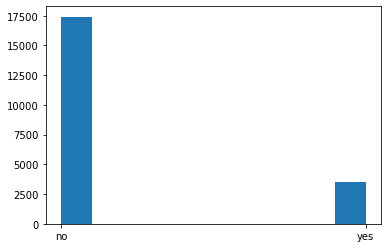

In [17]:
plt.hist(y_SMOTE)

# Undersampling

In [18]:
rs = RandomUnderSampler(sampling_strategy = 0.5,random_state = 16)

x_SMOTE, y_SMOTE = rs.fit_resample(x_SMOTE, y_SMOTE)

(array([6964.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3482.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

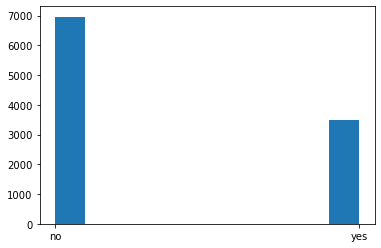

In [19]:
plt.hist(y_SMOTE)

# Feature Selection

Four methods were used to produce the 20 most important features for each method and then the a final list of features was made by combining the unique features from all 4 methods.

In [20]:
threshold = 0.90

vt = VarianceThreshold().fit(x_SMOTE)

feat_var_threshold = x_SMOTE.columns[vt.variances_ > threshold * (1-threshold)]
feat_var_threshold

Index(['age', 'Money', 'day', 'Time', 'Doctor_visits', 'last_visit',
       'cured_in', 'Profession_blue-collar', 'Profession_management',
       'Profession_technician', 'Profession_admin.', 'Month_may', 'Month_jul',
       'Month_aug', 'Month_jun', 'edu_secondary', 'edu_tertiary',
       'edu_primary', 'Status_married', 'Status_single', 'residence_no',
       'prev_diagnosed_no', 'communication_cellular', 'communication_unknown',
       'side_effects_unknown', 'side_effects_failure'],
      dtype='object')

In [21]:
model = RandomForestClassifier(random_state = 42)
model.fit(x_SMOTE, y_SMOTE)

feature_imp = pd.DataFrame(model.feature_importances_, index=x_SMOTE.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

Index(['Time', 'Money', 'age', 'day', 'last_visit', 'Doctor_visits',
       'side_effects_success', 'communication_unknown', 'residence_no',
       'cured_in', 'side_effects_failure', 'Month_may', 'Status_married',
       'side_effects_unknown', 'Month_jul', 'Month_aug', 'Month_nov',
       'communication_cellular', 'edu_secondary', 'Month_apr'],
      dtype='object')

In [22]:
X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(x_SMOTE)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, y_SMOTE)
feature_scoring = pd.DataFrame({
        'feature': x_SMOTE.columns,
        'score': X_scored.scores_
    })

feat_scored_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
feat_scored_20

array(['side_effects_success', 'communication_unknown', 'Month_may',
       'Time', 'Profession_blue-collar', 'residence_no',
       'side_effects_unknown', 'communication_cellular', 'Status_married',
       'edu_primary', 'edu_secondary', 'Profession_services', 'Month_jul',
       'Month_jun', 'last_visit', 'Profession_technician', 'Month_nov',
       'cured_in', 'Month_apr', 'Month_aug'], dtype=object)

In [23]:
rfe = RFE(LogisticRegression(random_state = 42), 20)
rfe.fit(x_SMOTE, y_SMOTE)

feature_rfe_scoring = pd.DataFrame({
        'feature': x_SMOTE.columns,
        'score': rfe.ranking_
    })

feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
feat_rfe_20

array(['Profession_blue-collar', 'Profession_management',
       'Profession_technician', 'Profession_admin.',
       'Profession_services', 'Month_may', 'Month_jul', 'Month_aug',
       'Month_jun', 'Month_nov', 'Month_apr', 'Month_feb',
       'edu_secondary', 'edu_tertiary', 'edu_primary', 'Status_married',
       'communication_unknown', 'side_effects_unknown',
       'side_effects_failure', 'side_effects_success'], dtype=object)

In [24]:
features = np.hstack([
        feat_var_threshold, 
        feat_imp_20,
        feat_scored_20,
        feat_rfe_20
    ])

features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))

Final features set:

	-Doctor_visits
	-Money
	-Month_apr
	-Month_aug
	-Month_feb
	-Month_jul
	-Month_jun
	-Month_may
	-Month_nov
	-Profession_admin.
	-Profession_blue-collar
	-Profession_management
	-Profession_services
	-Profession_technician
	-Status_married
	-Status_single
	-Time
	-age
	-communication_cellular
	-communication_unknown
	-cured_in
	-day
	-edu_primary
	-edu_secondary
	-edu_tertiary
	-last_visit
	-prev_diagnosed_no
	-residence_no
	-side_effects_failure
	-side_effects_success
	-side_effects_unknown


# Final Features

In [25]:
x_SMOTE = x_SMOTE.loc[:, features]
tmp2 = tmp2.loc[:, features]
tmp_test = tmp_test.loc[:, features]

x_SMOTE.shape,tmp_test.shape,tmp2.shape

((10446, 31), (8459, 31), (3000, 31))

# Gradient Boosting Classifier

GradientBoostingClassifier gave the best results after hyperparamter tuning using GridSearchCV.

In [26]:
gbm = GradientBoostingClassifier(learning_rate = 0.08, n_estimators = 100,min_samples_split = 100,min_samples_leaf = 30,
                                 max_depth = 5,subsample = 1.0,random_state = 16)

gbm.fit(x_SMOTE,y_SMOTE)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.08, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=30, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=16, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [27]:
pred = gbm.predict(tmp_test)

In [28]:
print(confusion_matrix(y_test,pred))

[[6840  633]
 [ 301  685]]


In [29]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

          no       0.96      0.92      0.94      7473
         yes       0.52      0.69      0.59       986

    accuracy                           0.89      8459
   macro avg       0.74      0.81      0.77      8459
weighted avg       0.91      0.89      0.90      8459



In [ ]:
from yellowbrick.model_selection import FeatureImportances

plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

gbm = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.08, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=30, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=16, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

viz = FeatureImportances(gbm)
viz.fit(x_SMOTE, y_SMOTE)
viz.show();

# Final Prediction

After studying the Kaggle score of previous submissions and respective classification matrices, we found that the model with the best Kaggle score had the highest 'recall' and the Kaggle score for the previous submissions decreased with a decrease in recall. So, instead of directly predicting 'yes/no' predictions, we predicted the probabilities of the observation being 'yes/no'. After fiddling with the threshold that decides whether an observation is classified as 'yes/no' (default = 0.5) we arrived at the final threshold of 0.24 that gave the best Kaggle score.

In [ ]:
test_pred = gbm.predict_proba(tmp2)

In [ ]:
pred_df = pd.DataFrame(data = test_pred,index = df['ID'])

In [ ]:
pred_df['Y'] = np.where(pred_df[1] > 0.24,'yes','no')

In [ ]:
pred_df.head()